# Trabajo práctico integrador - Aprendizaje de Máquina I

## Carrera de Especialización en Inteligencia Artificial / 23Co2025

### Alumnos:

* Paola Andrea Blanco     **(a2303)**
* Facundo Manuel Quiroga  **(a2305)**
* Juan Manuel Fajardo     **(a2310)**
* Victor Gabriel Peralta  **(a2322)**
* Agustín Jesús Vazquez   **(e2301)**

## 1. Introducción y objetivo de trabajo

**Fuente de información de evaluación:** Utilizaremos el dataset [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package), el cual comprende aproximadamente 10 años de observaciones diarias del clima en numerosos lugares de Australia.

**Objetivo:** Queremos predecir si lloverá o no al día siguiente en función de datos meteorológicos del día actual, para integrar esta información en una aplicación meteorológica que beneficie al público.

## 2. Carga de datos y análisis exploratorio (EDA)

En esta sección cargamos el conjunto de datos original y realizamos un breve análisis exploratorio para entender su estructura, distribuciones y valores faltantes.

In [18]:
# Importamos librerías necesarias para el desarrollo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Cargar dataset
df = pd.read_csv('dataset/weatherAUS.csv')

In [20]:
# Dimensiones del conjunto de datos
print(f"Filas y columnas del dataset: {df.shape}")
# Muestra las primeras 5 filas para observar las columnas
display(df.head())
# Contar valores faltantes por columna (top 10)
missing = df.isnull().sum().sort_values(ascending=False)
print("Valores faltantes por columna (top 10):")
print(missing.head(10))

Filas y columnas del dataset: (145460, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Valores faltantes por columna (top 10):
Sunshine         69835
Evaporation      62790
Cloud3pm         59358
Cloud9am         55888
Pressure9am      15065
Pressure3pm      15028
WindDir9am       10566
WindGustDir      10326
WindGustSpeed    10263
Humidity3pm       4507
dtype: int64


El dataset original tiene 23 columnas y 145.460 filas, incluyendo variables numéricas continuas (temperaturas, precipitaciones, humedad, presión, etc.), variables categóricas (ubicación geográfica, dirección del viento, etc.), y una columna de fecha. La variable objetivo es RainTomorrow (indicador Sí/No de si llovió al día siguiente). El análisis inicial revela qué columnas tienen datos faltantes y en qué proporción.

In [21]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [23]:
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [24]:
df.tail(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No
145459,2017-06-25,Uluru,14.9,NaN,0.0,NaN,NaN,NaN,NaN,ESE,...,62.0,36.0,1020.2,1017.9,8.0,8.0,15.0,20.9,No,NaN


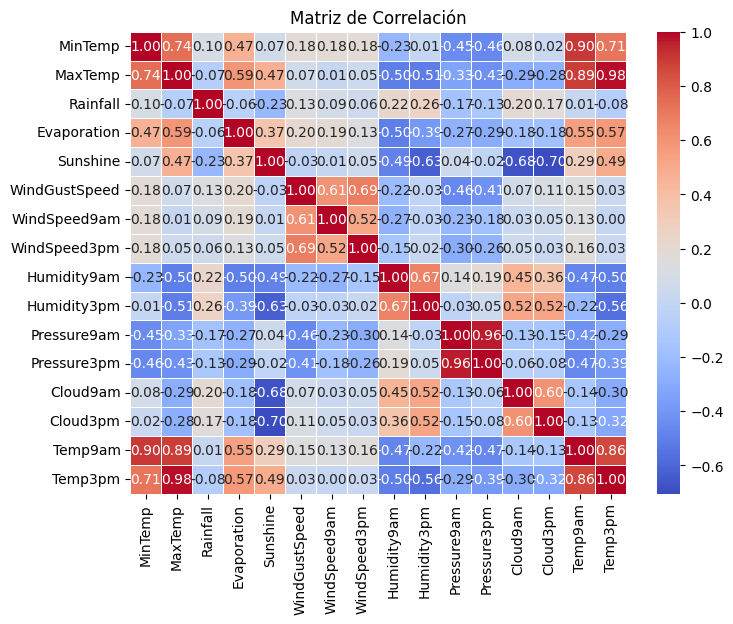

In [25]:
# Seleccionar solo columnas numéricas
numeric_df = df.select_dtypes(include='number')

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Crear un gráfico de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [26]:
# Distribución de la variable objetivo
df["RainTomorrow"].value_counts(normalize=True)


RainTomorrow
No     0.775819
Yes    0.224181
Name: proportion, dtype: float64

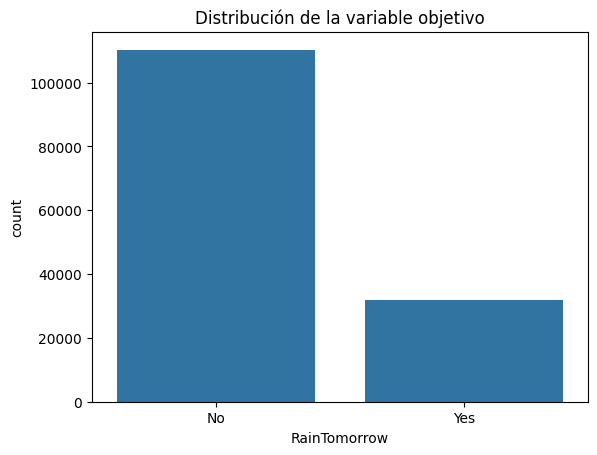

In [27]:
sns.countplot(x="RainTomorrow", data=df)
plt.title("Distribución de la variable objetivo")
plt.show()

Observamos que la variable objetivo está ligeramente desbalanceada, con una proporción mayor de "No" respecto de "Yes". Esto es esperable en un dataset meteorológico, ya que la mayoría de los días no llueve. Este desbalance será tenido en cuenta al evaluar el modelo.

## Preprocesamiento de datos

### 3.1 Preprocesamiento estructural 

En esta sección dejamos el dataset listo para entrenar modelos de clasificación. Los pasos principales son:
1. Eliminación de columnas con alto porcentaje de datos faltantes.
2. Eliminar las filas que no tienen valor en la variable objetivo `RainTomorrow`.
3. Transformar la fecha en una representación cíclica del mes (`Month_sin`, `Month_cos`).

Decidimos no incluir la variable Year como feature porque no aporta información predictiva relevante para la probabilidad de lluvia diaria. La variabilidad interanual en este dataset no representa una tendencia significativa y podría introducir ruido en el modelo. En cambio, la estacionalidad mensual sí es relevante, y por ello se incorporó mediante una codificación cíclica (Month_sin y Month_cos).



In [ ]:
# Importar funciones de preprocesamiento desde el módulo
from models import preprocessing

# 1. Limpiar datos 
df_clean = preprocessing.preparar_dataframe(df, target_col="RainTomorrow")

y = df_clean["RainTomorrow"].map({"No": 0, "Yes": 1})
X = df_clean.drop(columns=["RainTomorrow"])

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Columnas categóricas:")
print(cat_cols)

print("\nColumnas numéricas (primeras 10):")
print(num_cols[:10])


Columnas categóricas:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

Columnas numéricas (primeras 10):
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm']


### 3.2 Train/Test Split

Se divide en conjunto de entrenamiento y prueba (80% train, 20% test)

In [29]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Tamaño de X_train:", X_train.shape, " - Tamaño de X_test:", X_test.shape)
print("Distribución de clases en y_train:")
print(y_train.value_counts())
print("Distribución de clases en y_test:")
print(y_test.value_counts())


Tamaño de X_train: (113754, 23)  - Tamaño de X_test: (28439, 23)
Distribución de clases en y_train:
RainTomorrow
No     88252
Yes    25502
Name: count, dtype: int64
Distribución de clases en y_test:
RainTomorrow
No     22064
Yes     6375
Name: count, dtype: int64


## 4. Entrenamiento y evaluación de modelos

### 4.1 Preprocesadores

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Para modelos de árboles (sin escalado)
numeric_transformer_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Para regresión logística / KNN (con escalado)
numeric_transformer_scaled = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_tree, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

preprocessor_scaled = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_scaled, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


### 4.2 Regresion Logistica

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_scaled),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg_pipeline.fit(X_train, y_train)
y_pred_lr = log_reg_pipeline.predict(X_test)
y_prob_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("Accuracy Regresión Logística:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Accuracy Regresión Logística: 0.8493617919054819
              precision    recall  f1-score   support

          No       0.87      0.95      0.91     22064
         Yes       0.73      0.51      0.61      6375

    accuracy                           0.85     28439
   macro avg       0.80      0.73      0.76     28439
weighted avg       0.84      0.85      0.84     28439



### 4.2 KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_scaled),      # imputación + OneHot + scaler
    ("model", KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)
y_prob_knn = knn_pipeline.predict_proba(X_test)[:, 1]

print("Accuracy KNN:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

KeyboardInterrupt: 

### 4.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_tree),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Accuracy Random Forest:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Accuracy Random Forest: 0.8582580259502796
              precision    recall  f1-score   support

          No       0.87      0.96      0.91     22064
         Yes       0.79      0.51      0.62      6375

    accuracy                           0.86     28439
   macro avg       0.83      0.73      0.76     28439
weighted avg       0.85      0.86      0.85     28439



### 4.4 XGBoost

In [32]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_tree),  # imputación num/cat + OneHot
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss"   # para binaria
    ))
])

xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['No' 'Yes']

## 4. Entrenamiento y evaluación de modelos

Entrenaremos cinco modelos de clasificación binaria distintos utilizando el conjunto de entrenamiento:
- **Regresión Logística**
- **Naive Bayes (Gaussiano)**
- **K-Nearest Neighbors (KNN)**
- **Random Forest**

Usaremos implementaciones de scikit-learn, encapsuladas en funciones modulares. Cada función entrena su modelo y realiza predicciones sobre el conjunto de prueba. Luego evaluaremos el desempeño de cada modelo mediante métricas como **Accuracy**, **Precision**, **Recall**, **F1-score** y **Brier score**, además de visualizar la matriz de confusión.

In [12]:
# Importar módulos de modelos y métricas
from models import logistic_regression, naive_bayes, knn, random_forest
from models import metrics_utils

# Entrenar y predecir con cada modelo
models = {}
predictions = {}  # para guardar predicciones y probabilidades
metrics_results = {}

# 3.1 Regresión Logística
print("Entrenando modelo de Regresión Logística...")
model_log, y_pred_log, y_prob_log = logistic_regression.train_and_predict(X_train_proc, y_train, X_test_proc)
models['Logistic'] = model_log
predictions['Logistic'] = (y_pred_log, y_prob_log)
metrics_results['Logistic'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_log, y_prob_log)
print("Métricas Regresión Logística:", metrics_results['Logistic'])

Entrenando modelo de Regresión Logística...
Métricas Regresión Logística: {'accuracy': 0.8468554056621699, 'precision': 0.7274330042313117, 'recall': 0.5018243736317197, 'f1': 0.5939254354397582, 'brier_score': 0.11198761200849769}


In [13]:
# 3.2 Naive Bayes Gaussiano
print("\nEntrenando modelo de Naive Bayes...")
model_nb, y_pred_nb, y_prob_nb = naive_bayes.train_and_predict(X_train_proc, y_train, X_test_proc)
models['NaiveBayes'] = model_nb
predictions['NaiveBayes'] = (y_pred_nb, y_prob_nb)
metrics_results['NaiveBayes'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_nb, y_prob_nb)
print("Métricas Naive Bayes:", metrics_results['NaiveBayes'])


Entrenando modelo de Naive Bayes...
Métricas Naive Bayes: {'accuracy': 0.6266659428354279, 'precision': 0.33671782762691854, 'recall': 0.6937484796886403, 'f1': 0.453382084095064, 'brier_score': 0.34188438405351085}


In [14]:
# 3.3 K-Nearest Neighbors
print("\nEntrenando modelo KNN...")
model_knn, y_pred_knn, y_prob_knn = knn.train_and_predict(X_train_proc, y_train, X_test_proc)
models['KNN'] = model_knn
predictions['KNN'] = (y_pred_knn, y_prob_knn)
metrics_results['KNN'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_knn, y_prob_knn)
print("Métricas KNN:", metrics_results['KNN'])


Entrenando modelo KNN...


Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\agust\anaconda3\envs\ia-env\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\agust\anaconda3\envs\ia-env\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\agust\anaconda3\envs\ia-env\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\agust\anaconda3\envs\ia-env\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Users\agust\anaconda3\envs\ia-env\Lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf3 in position 138: invalid continuation byte


Métricas KNN: {'accuracy': 0.8015526180071116, 'precision': 0.5966475705495438, 'recall': 0.3420092434930674, 'f1': 0.43478933127174335, 'brier_score': 0.14839010884612253}


In [15]:
# 3.4 Random Forest
print("\nEntrenando modelo Random Forest...")
model_rf, y_pred_rf, y_prob_rf = random_forest.train_and_predict(X_train_proc, y_train, X_test_proc)
models['RandomForest'] = model_rf
predictions['RandomForest'] = (y_pred_rf, y_prob_rf)
metrics_results['RandomForest'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_rf, y_prob_rf)
print("Métricas Random Forest:", metrics_results['RandomForest'])


Entrenando modelo Random Forest...
Métricas Random Forest: {'accuracy': 0.850981243723026, 'precision': 0.7636047857969895, 'recall': 0.48126976404767696, 'f1': 0.590420769919427, 'brier_score': 0.10874579951684266}


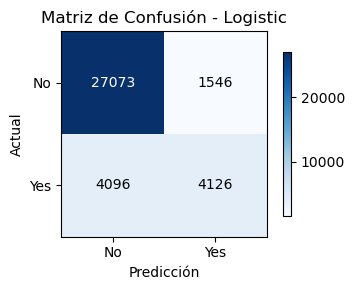

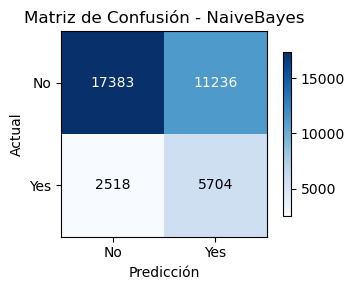

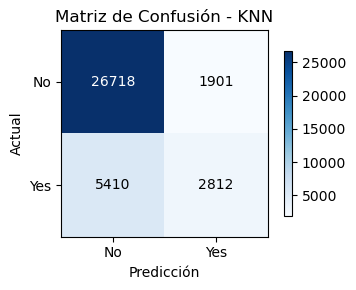

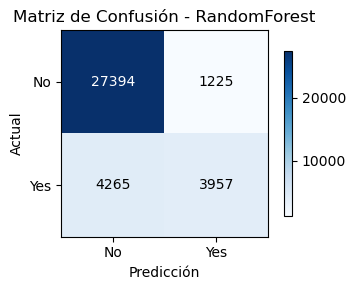

In [16]:
# 3.5 Visualización de matrices de confusión para cada modelo
import matplotlib.pyplot as plt

for model_name, (y_pred, y_prob) in predictions.items():
    metrics_utils.plot_confusion_matrix(y_test, y_pred, title=f"Matriz de Confusión - {model_name}")
    plt.show()

## 5. Calibración de probabilidades

Algunos modelos (especialmente Random Forest, etc.) pueden no estar bien **calibrados** en términos de probabilidad – es decir, la probabilidad estimada de "lluvia" podría no reflejar la frecuencia real observada. Por ejemplo, puede predecir "0.9" de probabilidad de lluvia en muchos casos donde en realidad sólo llueve en un 70% de ellos (sobreestimación). Para mejorar esto, aplicamos **calibración** de probabilidades:
- **Platt Scaling (Sigmoide)**: ajusta una regresión logística sobre las salidas del modelo original.
- **Isotonic Regression (Regresión Isotónica)**: ajusta un modelo no paramétrico monotónico sobre las probabilidades, más flexible pero con riesgo de sobreajuste si hay pocos datos.

A continuación calibramos el modelo Random Forest (uno de los más precisos) usando ambos métodos y comparamos.

In [ ]:
from models import calibratecopy1

# Calibrar Random Forest con Platt Scaling (sigmoide) usando validación cruzada en el conjunto de entrenamiento
calibrated_rf_platt = calibratecopy1.calibrate_platt_cv(X_train_proc, y_train, model_rf)
# Calibrar Random Forest con Regresión Isotónica
calibrated_rf_iso = calibratecopy1.calibrate_isotonic_cv(X_train_proc, y_train, model_rf)

# Obtener nuevas probabilidades calibradas en el conjunto de prueba
y_prob_rf_platt = calibrated_rf_platt.predict_proba(X_test_proc)[:, 1]
y_prob_rf_iso   = calibrated_rf_iso.predict_proba(X_test_proc)[:, 1]

# Calcular Brier score antes y después de calibración
brier_before = metrics_utils.brier_score(y_test, y_prob_rf)
brier_platt  = metrics_utils.brier_score(y_test, y_prob_rf_platt)
brier_iso    = metrics_utils.brier_score(y_test, y_prob_rf_iso)
print(f"Brier score (Random Forest) sin calibrar: {brier_before:.4f}")
print(f"Brier score calibrado (Platt): {brier_platt:.4f}")
print(f"Brier score calibrado (Isotónica): {brier_iso:.4f}")

In [ ]:
# Graficar curvas de calibración (diagramas de confiabilidad) para Random Forest antes y después
plt.figure(figsize=(6,4))
metrics_utils.plot_calibration_curve(y_test, y_prob_rf, label="RF sin calibrar")
metrics_utils.plot_calibration_curve(y_test, y_prob_rf_platt, label="RF calibrado (Platt)")
metrics_utils.plot_calibration_curve(y_test, y_prob_rf_iso, label="RF calibrado (Isotónica)")
plt.title("Curvas de Calibración - Random Forest")
plt.legend(loc="upper left")
plt.show()